In [1]:
import os
from skimage import io
import csv
from sklearn.model_selection import train_test_split
from torchvision.utils import make_grid
from torchvision import datasets, transforms, models
from torchvision.transforms import v2
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler, Dataset
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import random
import numpy as np
%matplotlib inline

C:\Users\Nick\anaconda3\envs\pytorch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import transformers
from transformers import (
    ViTConfig,
    ViTImageProcessor,
    ViTMAEConfig,
    ViTMAEForPreTraining,
)

In [3]:
RESOLUTION = 224

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=RESOLUTION, scale=(0.67, 1.0), ratio=(3.0 / 4.0, 4.0 / 3.0)),
    v2.RandomHorizontalFlip(),
    v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),  # Transform to tensor
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # ImageNet standards
])

# Define a transform for the validation data without data augmentation
val_transform = transforms.Compose([
    v2.Resize((RESOLUTION, RESOLUTION)),  # Resize images to a common size
    v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),  # Transform to tensor
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # ImageNet standards
])

In [4]:
csv_path = 'train_labeled.csv'
labeled_path = 'train/labeled'

class CustomDataset(Dataset):
    def __init__(self, csv_file, train_path, transform=None):
        self.train_labeled = train_path
        self.df = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.train_labeled + '/' + self.df.image[idx]
        image = datasets.folder.default_loader(img_path)
        label = self.df.id[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

labeled_train_dataset = CustomDataset(csv_path, labeled_path, train_transform)
labeled_val_dataset = CustomDataset(csv_path, labeled_path, val_transform)

num_train = len(labeled_train_dataset)
indices = list(range(num_train))
split_idx = int(np.floor(.1 * num_train))
valid_idx, train_idx = indices[:split_idx], indices[split_idx:]

train_indices, val_indices = train_test_split(indices, test_size=.2)
labeled_train_dataset = torch.utils.data.Subset(labeled_train_dataset, train_indices)
labeled_val_dataset = torch.utils.data.Subset(labeled_val_dataset, val_indices)

In [5]:
labeled_train_dataset.dataset.df

,image,id
0,00000.jpg,11
1,00001.jpg,117
2,00002.jpg,22
3,00003.jpg,63
4,00004.jpg,131
...,...,...
9849,09849.jpg,0
9850,09850.jpg,12
9851,09851.jpg,89
9852,09852.jpg,13


In [6]:
print(len(labeled_train_dataset), len(labeled_val_dataset))

7883 1971


In [7]:
BATCH_SIZE = 32
train_label_loader = DataLoader(dataset=labeled_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_label_loader = DataLoader(dataset=labeled_val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [9]:
base_mae_model = ViTMAEForPreTraining.from_pretrained('mae_pretrained')

In [10]:
criterion = nn.L1Loss() # do we need this?
optimizer = torch.optim.Adam(base_mae_model.parameters())

In [11]:
unlabeled_path = 'train/unlabeled'

# For the test set, since there are no labels, we need to create a custom DataSet.
class UnlabeledDataset(datasets.VisionDataset):
    def __init__(self, root, transform=None):
        super(UnlabeledDataset, self).__init__(root, transform=transform)
        self.images = [os.path.join(root, img) for img in os.listdir(root)]

    def __getitem__(self, index):
        image_path = self.images[index]
        image = datasets.folder.default_loader(image_path)  # default loader is PIL.Image.open
        if self.transform:
            image = self.transform(image)
        return image, str(image_path)

    def __len__(self):
        return len(self.images)
    # def remove_from_ds(image_path):
        
        

# Create a dataset for your test data
unlabeled_ds = UnlabeledDataset(root=unlabeled_path, transform=val_transform)

# Create a DataLoader for your test set
unlabel_loader = DataLoader(dataset=unlabeled_ds, batch_size=BATCH_SIZE, shuffle=True)
print(len(unlabeled_ds))

22995


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
base_mae_model.to(device)

num_epochs = 30

# Lists for tracking loss and accuracy
train_losses = []

for epoch in range(num_epochs):
    # Training phase
    base_mae_model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with tqdm(unlabel_loader, unit="batch") as tepoch:
        for images, labels in tepoch:
            tepoch.set_description(f"Epoch {epoch+1}/{num_epochs}")

            images = images.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = base_mae_model(images)

            # Calculate loss
            loss = outputs.loss
            running_loss += loss.item() * images.size(0)
            total_predictions += len(labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Update progress bar
            tepoch.set_postfix(loss=(running_loss / total_predictions))

    # Calculate and print loss and accuracy for the training phase
    torch.save(base_mae_model.state_dict(), 'pre_trained_model.pt')
    epoch_loss = running_loss / len(train_label_loader.dataset)
    train_losses.append(epoch_loss)

Epoch 10/30:  11%|█         | 80/719 [06:17<50:13,  4.72s/batch, loss=0.277]


KeyboardInterrupt: 

In [13]:
base_mae_model.save_pretrained('mae_pretrained')

In [14]:
from transformers import ViTMAEForPreTraining
from transformers import ViTFeatureExtractor
import requests
from PIL import Image

url = "https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg"
image = Image.open(requests.get(url, stream=True).raw)

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def visualize(pixel_values, model):
    # forward pass
    model.to('cpu')
    outputs = model(pixel_values)
    y = model.unpatchify(outputs.logits)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = outputs.mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.config.patch_size**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()

    x = torch.einsum('nchw->nhwc', pixel_values)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

C:\Users\Nick\anaconda3\envs\pytorch\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
C:\Users\Nick\anaconda3\envs\pytorch\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


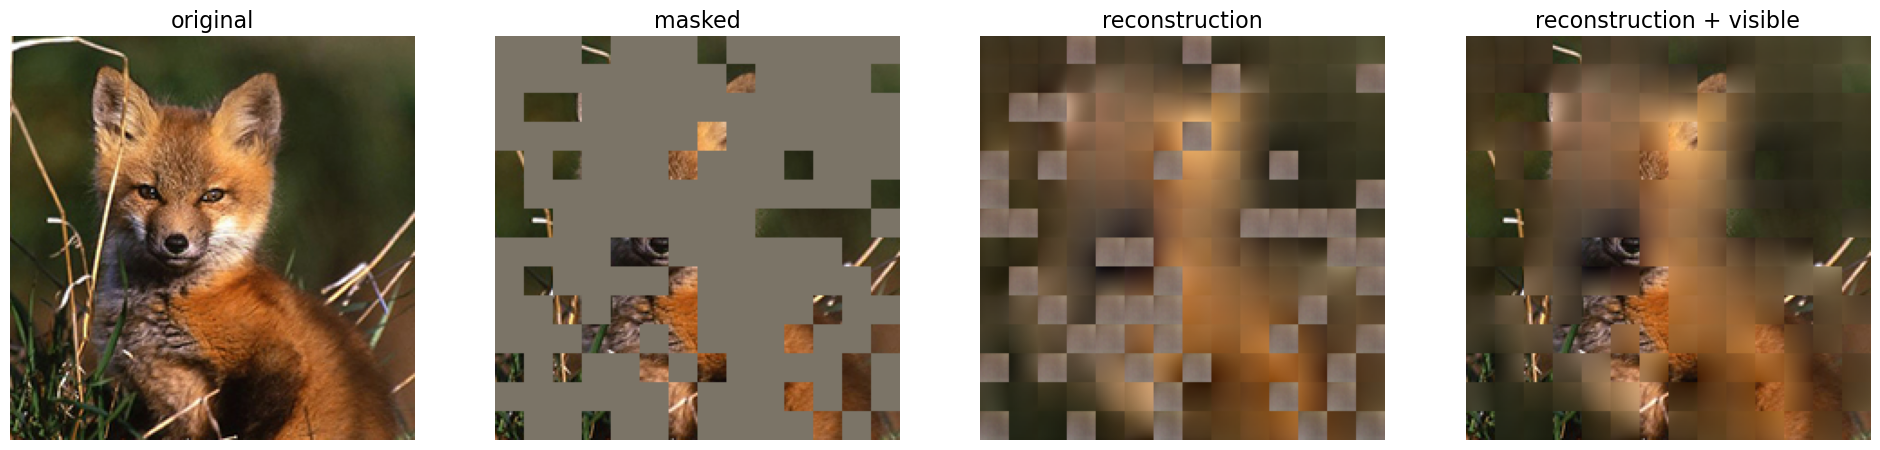

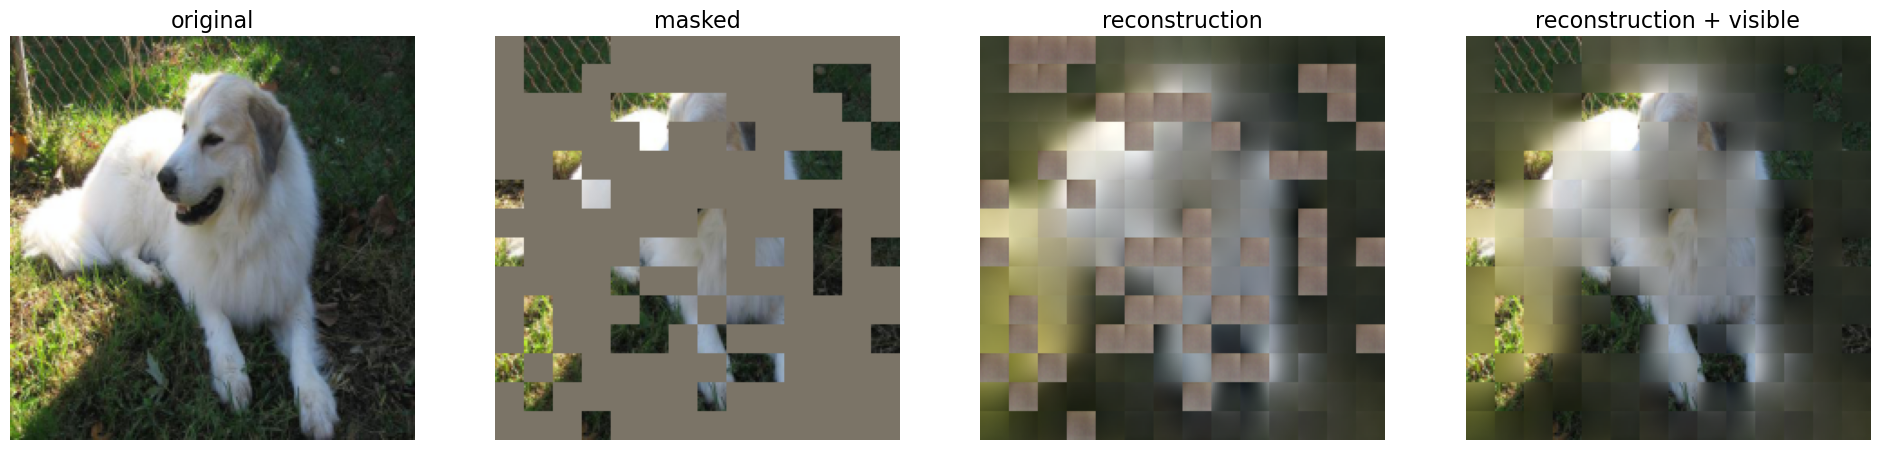

In [16]:
feature_extractor = ViTFeatureExtractor.from_pretrained("facebook/vit-mae-base")
pixel_values = feature_extractor(image, return_tensors="pt").pixel_values

# # make random mask reproducible (comment out to make it change)
# torch.manual_seed(2)

model3 = ViTMAEForPreTraining.from_pretrained('mae_pretrained')

train_iter = iter(train_label_loader)
images, labels = next(train_iter)

visualize(pixel_values, model3)
visualize(images, model3)

In [21]:
base_mae_model.save_pretrained('mae_pretrain')

In [17]:
torch.cuda.empty_cache()

In [18]:
from transformers import ViTForImageClassification

model2 = ViTForImageClassification.from_pretrained('mae_vit_classify', ignore_mismatched_sizes=True)

model2.classifier = nn.Linear(768, 135)
model = model2

You are using a model of type vit_mae to instantiate a model of type vit. This is not supported for all configurations of models and can yield errors.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at mae_pretrain and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [53]:
# class ModifiedViT(nn.Module):
#     def __init__(self, model):
#         super(ModifiedViT, self).__init__()
#         self.model = model
#         for param in self.model.vit.encoder.parameters():
#             param.requires_grad = False
#         p = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
#         print(p)

#     def forward(self, x):
#         x = self.model(x)
#         return x

# # Create the modified model
# model = ModifiedViT(model)

848007


In [40]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [36]:
#collapse-hide

# learning rate
lr      = 1e-2
lr_mult = 0.65

# placeholder
parameters      = []
prev_group_name = layer_names[0].split('.')[0]

# store params & learning rates
for idx, name in enumerate(layer_names):
    if idx < 4:
        cur_group_name = name.split('.')[0]
    else:
        cur_group_name = name.split('.')[4]
    
    # update learning rate
    if cur_group_name != prev_group_name:
        lr *= lr_mult
    prev_group_name = cur_group_name
    
    # display info
    print(f'{idx}: lr = {lr:.6f}, {name}')
    
    # append layer parameters
    parameters += [{'params': [p for n, p in model.named_parameters() if n == name and p.requires_grad],
                    'lr':     lr}]

0: lr = 0.010000, classifier.bias
1: lr = 0.010000, classifier.weight
2: lr = 0.006500, vit.layernorm.bias
3: lr = 0.006500, vit.layernorm.weight
4: lr = 0.004225, vit.encoder.layer.11.layernorm_after.bias
5: lr = 0.004225, vit.encoder.layer.11.layernorm_after.weight
6: lr = 0.002746, vit.encoder.layer.11.layernorm_before.bias
7: lr = 0.002746, vit.encoder.layer.11.layernorm_before.weight
8: lr = 0.001785, vit.encoder.layer.11.output.dense.bias
9: lr = 0.001785, vit.encoder.layer.11.output.dense.weight
10: lr = 0.001160, vit.encoder.layer.11.intermediate.dense.bias
11: lr = 0.001160, vit.encoder.layer.11.intermediate.dense.weight
12: lr = 0.000754, vit.encoder.layer.11.attention.output.dense.bias
13: lr = 0.000754, vit.encoder.layer.11.attention.output.dense.weight
14: lr = 0.000754, vit.encoder.layer.11.attention.attention.value.bias
15: lr = 0.000754, vit.encoder.layer.11.attention.attention.value.weight
16: lr = 0.000754, vit.encoder.layer.11.attention.attention.key.bias
17: lr = 0.

IndexError: list index out of range

In [41]:
# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(parameters)

In [ ]:
# Send the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training loop
num_epochs = 12  # Replace with the number of epochs you want

# Lists for tracking loss and accuracy
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
highest_acc = 0

for epoch in range(num_epochs):
    # Training phase
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with tqdm(train_label_loader, unit="batch") as tepoch:
        for images, labels in tepoch:
            tepoch.set_description(f"Epoch {epoch+1}/{num_epochs}")

            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            outputs = outputs.logits

            # Calculate loss
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

            # Update progress bar
            tepoch.set_postfix(loss=(running_loss / total_predictions), accuracy=(correct_predictions / total_predictions))

    # Calculate and print loss and accuracy for the training phase
    epoch_loss = running_loss / len(train_label_loader.dataset)
    epoch_accuracy = correct_predictions / total_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    val_correct_predictions = 0
    val_total_predictions = 0

    # Disable gradient calculation for validation to save memory and computations
    with torch.no_grad():
        with tqdm(val_label_loader, unit="batch") as vepoch:
            for images, labels in vepoch:
                vepoch.set_description(f"Validation Epoch {epoch+1}/{num_epochs}")

                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = model(images)
                outputs = outputs.logits

                # Calculate loss
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * images.size(0)

                # Calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                val_total_predictions += labels.size(0)
                val_correct_predictions += (predicted == labels).sum().item()

                # Update progress bar
                vepoch.set_postfix(val_loss=(val_running_loss / val_total_predictions), val_accuracy=(val_correct_predictions / val_total_predictions))

    # Calculate and print loss and accuracy for the validation phase
    val_epoch_loss = val_running_loss / len(val_label_loader.dataset)
    val_epoch_accuracy = val_correct_predictions / val_total_predictions
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_accuracy)

    if val_epoch_accuracy > highest_acc:
        model.save_pretrained('mae_vit_classify')

    # Print summary for the epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}, Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_epoch_accuracy:.4f}')

In [45]:
model.save_pretrained('mae_vit_classify')